In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
os.chdir('/home/vaschetti/maxarSrc/src')
import sys
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch
from time import time
from random import randint

from my_functions.samplers_utils import boundingBox_2_Polygon
from my_functions.geoDatasets import Maxar
from my_functions.samplers import MyGridGeoSampler
from my_functions.segment import building_gdf, rel_bbox_coords, rel_polyg_coord

In [3]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
size = 608
sampler = MyGridGeoSampler(dataset, size=size, stride=size)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

root = '/home/vaschetti/maxarSrc'

gdfs_32628 = building_gdf('TheGambia', os.path.join(root, 'metadata/buildings_dataset_links.csv'),  dataset_crs = data_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
[[584.257634116745, 584.4463271919251, 665.9304497817993, 697.7324707107543], [573.3218627033234, 254.15413574066162, 633.2193528644561, 322.0308078514099], [-53.90017359046936, 563.9516881713868, 58.0072256023407, 644.0465085395813], [548.8009117109299, 574.279247618103, 586.8041426275254, 608.3443722557067], [482.05656668510437, 473.7482720664978, 534.2432684457779, 554.702392250824], [337.74433772735597, 486.4160761291504, 404.0177671226501, 539.5034782478333], [423.59411786766054, 459.91105342559814, 494.0053453876495, 519.8657271408081], [543.3449476079941, 460.70700212631226, 593.0470942361832, 515.0365134170532], [475.04661946525573, 446.2348684585571, 516.1246942111969, 482.3592185043335], [404.1336957590103, 428.14723451461794, 458.0534150707245, 473.43005940170286], [37.35785643844604, 561.1920272796

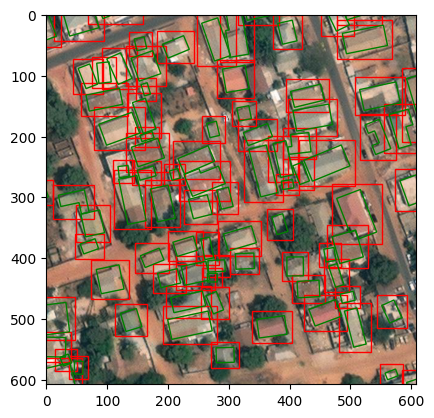

In [4]:
dataset_res = dataset.res
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)
    if len(hits) > 10: #per prendere immagini con almeno X edifici
        i+=1
        if i == 10 :#randint(0, 20): #per prendere immagini random
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            #predictor.set_image(img4Sam) #encoding the image

            #Getting the relative coordinates of the buildings boxes (list of lists)
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=5)
            
            #Plotting
            fig, ax = dataset.plot(sample)   
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
                ax.add_patch(rect)
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(poly)

            break

In [5]:
sys.path.append('/home/vaschetti/maxarSrc/models/EfficientSAM')
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Build the model
device = 'cuda:0'
ESAM_root = '/home/vaschetti/maxarSrc/models/EfficientSAM'
efficient_sam = build_efficient_sam_vitt(os.path.join(ESAM_root, 'weights/efficient_sam_vitt.pt')).to(device)

In [10]:
# load an image
sample_image_np = img4Sam
sample_image_tensor = transforms.ToTensor()(sample_image_np)
sample_image_tensor = sample_image_tensor.to(device)
print('sample_image_tensor:', sample_image_tensor.shape)

#right format for prompt
t_build_boxes = torch.tensor(building_boxes, device=device)
print('building boxes:', t_build_boxes.shape)
ESAM_boxes = t_build_boxes.unsqueeze(0)
ESAM_boxes = ESAM_boxes.reshape(-1,2,2)
print('ESAM_boxes:', ESAM_boxes.shape)

sample_image_tensor: torch.Size([3, 608, 608])
building boxes: torch.Size([86, 4])
ESAM_boxes: torch.Size([86, 2, 2])


In [7]:
input_points = ESAM_boxes.unsqueeze(0) #[B, max_num_queries, num_pts, 2] = [B, #boxes, 2, 2] unsqueeze to add the batch dim
input_labels = torch.tensor([[[2,3]]*input_points.shape[1]], device=device) #[B, max_num_queries, num_pts = 2]

print(input_points.shape)
print(input_labels.shape)

torch.Size([1, 86, 2, 2])
torch.Size([1, 86, 2])


## New batched inference

In [8]:
batched_images = sample_image_tensor.unsqueeze(0)
batch_size, _, input_h, input_w = batched_images.shape
embed_t0 = time()
image_embeddings = efficient_sam.get_image_embeddings(batched_images)
embed_t1 = time()
print(f'Time to embed {batched_images.shape[0]} images: {embed_t1 - embed_t0:.4f} (s)')

Time to embed 1 images: 0.2228 (s)


In [9]:
x = torch.randn(10000, 10000, device='cuda:1')

In [10]:
cpu_x = x.cpu()
del x
torch.cuda.empty_cache()

In [11]:
"""stop = input_points.shape[1]
num_parallel_queries = 50
total_t0 = time()
prediction_t_total = 0
for i in range(0, stop , num_parallel_queries):
    start_idx = i
    end_idx = min(i + num_parallel_queries, stop)
    prediction_t0 = time()
    predicted_logits, predicted_iou = efficient_sam.predict_masks(image_embeddings,
                                                              input_points[:, start_idx: end_idx],
                                                              input_labels[:, start_idx: end_idx],
                                                              multimask_output=True,
                                                              input_h = input_h,
                                                              input_w = input_w,
                                                              output_h=input_h,
                                                              output_w=input_w)
    prediction_t_total += time() - prediction_t0
    
    if i == 0:
        print('predicetd_logits:', predicted_logits.shape)
        cpu_complete_masks = predicted_logits[:,:,0].cpu()
    else:
        cpu_complete_masks = torch.cat((cpu_complete_masks, predicted_logits[:,:,0].cpu()), dim=1)
    
    del predicted_logits, predicted_iou
    torch.cuda.empty_cache()

total_t1 = time()
print(cpu_complete_masks.shape)
print('Prediction time', prediction_t_total)
print('Total time:', total_t1 - total_t0)"""

"stop = input_points.shape[1]\nnum_parallel_queries = 50\ntotal_t0 = time()\nprediction_t_total = 0\nfor i in range(0, stop , num_parallel_queries):\n    start_idx = i\n    end_idx = min(i + num_parallel_queries, stop)\n    prediction_t0 = time()\n    predicted_logits, predicted_iou = efficient_sam.predict_masks(image_embeddings,\n                                                              input_points[:, start_idx: end_idx],\n                                                              input_labels[:, start_idx: end_idx],\n                                                              multimask_output=True,\n                                                              input_h = input_h,\n                                                              input_w = input_w,\n                                                              output_h=input_h,\n                                                              output_w=input_w)\n    prediction_t_total += time() - prediction_t0\n    \

In [12]:
stop = input_points.shape[1]
num_parallel_queries = 50
total_t0 = time()
prediction_t_total = 0
for i in range(0, stop , num_parallel_queries):
    start_idx = i
    end_idx = min(i + num_parallel_queries, stop)
    prediction_t0 = time()
    predicted_logits, predicted_iou = efficient_sam.predict_masks(image_embeddings,
                                                              input_points[:, start_idx: end_idx],
                                                              input_labels[:, start_idx: end_idx],
                                                              multimask_output=True,
                                                              input_h = input_h,
                                                              input_w = input_w,
                                                              output_h=input_h,
                                                              output_w=input_w)
    prediction_t_total += time() - prediction_t0
    
    if i == 0:
        print('predicetd_logits:', predicted_logits.shape)
        np_complete_masks = predicted_logits[:,:,0].cpu().detach().numpy()
    else:
        np_complete_masks = np.concatenate((np_complete_masks, predicted_logits[:,:,0].cpu().detach().numpy()), axis=1)
    
    del predicted_logits, predicted_iou
    torch.cuda.empty_cache()

total_t1 = time()
print(np_complete_masks.shape)
print('Prediction time', prediction_t_total)
print('Total time:', total_t1 - total_t0)

predicetd_logits: torch.Size([1, 50, 3, 608, 608])
(1, 86, 608, 608)
Prediction time 0.17040562629699707
Total time: 0.6081838607788086


* predicetd_logits: torch.Size([1, 50, 3, 608, 608])
* (1, 86, 608, 608)
* Prediction time 0.08286380767822266
* Total time: 0.675229549407959

In [13]:
np_final_mask = np.greater_equal(np_complete_masks, 0).any(axis=1)
np_final_mask.shape

(1, 608, 608)

In [14]:
from my_functions.plotting_utils import show_mask
    
def plot_w_wo_masks_ESAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

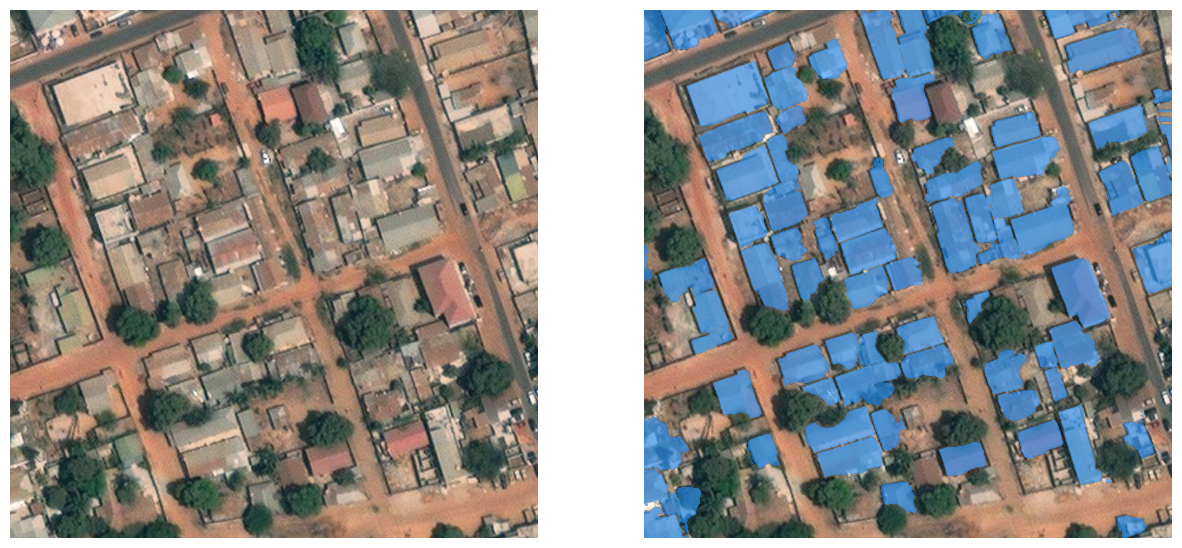

In [15]:
plot_w_wo_masks_ESAM(sample_image_np, np_final_mask[0])